In [1]:
import torch
import torch.nn.functional as F
from modeling_llama import LlamaForCausalLM
from transformers import LlamaTokenizer, cache_utils
from transformers.cache_utils import DynamicCache

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "meta-llama/Llama-2-7b-hf"  # Adjust based on your access
tokenizer = LlamaTokenizer.from_pretrained(model_name)
model = LlamaForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [4]:
import GPUtil



def get_gpu_usage():
    gpus = GPUtil.getGPUs()
    return gpus[0].memoryUsed

get_gpu_usage()

13163.0

In [5]:
from typing import List, Tuple

class SearchNode:
    def __init__(self, root, idx, token_id, token_score):
        self.root: 'SearchTree' = root
        self.idx: int = idx
        self.token_id: Tensor = token_id
        self.token_score: float = token_score
        self.parent: Optional['SearchNode'] = None
        self.children: List['SearchNode'] = []
        self.acc_score: float = token_score


    def add_children(self, child):
        self.children.append(child)
        child.parent = self
        child.acc_score = self.acc_score + child.token_score
        self.root.node_count += 1

    def delete_child(self, child):
        self.children.remove(child)
        self.root.node_count -= 1


class SearchTree:
    def __init__(self, beam_width=3):
        self.node_count: int = 0
        self.model = model
        self.device = model.device
        self.root: List[SearchNode] = []
        self.beam_width: int = beam_width



def dfs(searchNode: SearchNode, targets: List[int], traversed: List[int]) -> Tuple[bool, List[int], List[int]]:
    # returns found, found path, unused nodes
    traversed.append(searchNode.idx)
    if searchNode.idx in targets:
        return (True, traversed, [])
    
    if len(searchNode.children) == 0:
        return (False, [], traversed)
    
    if len(searchNode.children) == 1:
        return dfs(searchNode.children[0], targets, traversed)
    
    child_found = False
    found_path = []
    unused = []
    for child in searchNode.children:
        found, fp, u = dfs(child, targets, [])
        if found:
            found_path += fp
            child_found = True
        unused += u

    if child_found:
        found_path = traversed + found_path
    else:
        unused = traversed + unused
    
    return (child_found, found_path, unused)


def determine_unused_nodes(searchTree: SearchTree, targets: List[int]) -> Tuple[List[int], List[int]]:
    all_unused = []
    all_used = []
    for child in searchTree.root:
        _, used, unused = dfs(child, targets, [])
        all_unused += unused
        all_used += used
    return (all_used, all_unused)


def generate_causal_mask(searchTree: SearchTree,input_len: int,nodes: List[SearchNode]) -> torch.Tensor:
    branch_count = len(nodes)
    mask = torch.full((1, 1, branch_count, searchTree.node_count + input_len), -65504, device=device, dtype=torch.float16)
    mask[0, 0,:,:input_len] = 0
    tmp = nodes.copy()
    #print("========")
    while True:
        end = False
        for i in range(branch_count):
            #print(i, tmp[i].idx)
            mask[0, 0, i, tmp[i].idx + input_len] = 0
            if tmp[i].parent is not None:
                tmp[i] = tmp[i].parent
            else:
                end = True
        if end:
            return mask


def print_tree_state(searchTree: SearchTree,nodes: List[SearchNode]):
    branch_count = len(nodes)
    tmp = nodes.copy()
    print("========")
    print("node count: ", searchTree.node_count)
    while True:
        end = False
        for i in range(branch_count):
            print(i, tmp[i].idx)
            if tmp[i].parent is not None:
                tmp[i] = tmp[i].parent
            else:
                end = True
        if end:
            return


In [6]:
import torch
import torch.nn.functional as F
from collections import deque


def prune_kv_cache(past_key_values, input_length, remove_idx: List[int]):
    remove_idx = [i + input_length for i in remove_idx]
    print("remove", remove_idx)
    all_indices = torch.arange(past_key_values[0][0].size(2), device = "cuda:0")
    keep_indices = all_indices[~torch.isin(all_indices, torch.tensor(remove_idx, device="cuda:0"))]
    #print("keep", keep_indices)

    for i in range(len(past_key_values)):
        past_key_values.key_cache[i] = torch.index_select(past_key_values.key_cache[i], 2, keep_indices)
        past_key_values.value_cache[i] = torch.index_select(past_key_values.value_cache[i], 2, keep_indices)

def prune_tree(searchTree: SearchTree, remove_idx: List[int]):
    for child in searchTree.root[:]:
        if child.idx in remove_idx:
            #print("removed ", child.idx)
            searchTree.root.remove(child)
    tmp = deque(searchTree.root)
    while len(tmp) > 0:
        node = tmp.popleft()
        for child in node.children[:]:
            if child.idx in remove_idx:
                #print("removed ", child.idx)
                node.children.remove(child)
            else:
                tmp.append(child)

    i = 0

    tmp = deque(searchTree.root)
    while len(tmp) > 0:
        children = []
        while len(tmp) > 0:
            node = tmp.popleft()
            node.idx = i
            i += 1
            for child in node.children:
                children.append(child)
        children = sorted(children, key=lambda node: node.idx)
        tmp.extend(children)
    searchTree.node_count = i

def gc(searchTree: SearchTree,input_length, newest_branch: List[SearchNode], past_key_values):
    unused = determine_unused_nodes(searchTree, [ node.idx for node in newest_branch])
    #print("Unused: ", len(unused[1]), len(unused[0]) + len(unused[1]) , unused)
    prune_tree(searchTree, unused[1])
    kv = prune_kv_cache(past_key_values,input_length, unused[1])
    #print_tree_state(searchTree, newest_branch)
    return 

@torch.no_grad()
def generate_next_tokens(model, input_ids, beam_width = 3, max_tokens=300) -> Tuple[torch.Tensor, List[int]]:
    gpu_usage = []
    device = model.device
    past_key_values = None
    input_len = input_ids.shape[1]
    print("input length: ", input_len)

    #generate the first 3 tokens
    past_key_values = DynamicCache()
    outputs = model(input_ids, past_key_values=past_key_values, use_cache=True)
    past_key_values = outputs.past_key_values
    token_scores = F.log_softmax(outputs.logits, dim=-1)

    token_scores, tokens = torch.topk(token_scores, beam_width, dim=-1, largest=True, sorted=True)
    searchTree = SearchTree(beam_width = beam_width)
    newest_branch: List[SearchNode] = []
    idx = 0

    #define eos token
    eos_token_id = model.config.eos_token_id

    
    for i in range(beam_width):
        searchNode = SearchNode(searchTree, idx, tokens[0][-1][i], token_scores[0][-1][i])
        idx += 1
        newest_branch.append(searchNode)
        searchTree.root.append(searchNode)
        searchTree.node_count += 1
    
    completed_branches = []
    alive_beams = beam_width

    need_gc = False
    for i in range(input_len, max_tokens):
        if  ((i % 5 == 0 and alive_beams > 2) or need_gc) and True:
            print("gcccc")
            need_gc = False
            gc(searchTree,input_len, newest_branch, past_key_values)
            idx = searchTree.node_count
        print("gpu: ", get_gpu_usage())
        gpu_usage.append(get_gpu_usage())
        #construct position_ids
        #print("alive_beams: ", alive_beams)
        position_ids = torch.tensor([[i for _ in range(alive_beams)]], device=device)
        
        #construct attention_mask
        attention_mask = generate_causal_mask(searchTree,input_len , newest_branch)
        #print("attn", attention_mask.shape)
        #print("attn", attention_mask)
        #print(attention_mask[0][0])

        #construct input_ids
        input_ids = torch.tensor([[node.token_id for node in newest_branch]], device=device)
        
        #generate candidate tokens
        outputs = model(input_ids, past_key_values=past_key_values, position_ids=position_ids, attention_mask=attention_mask, use_cache=True)
        past_key_values = outputs.past_key_values
        #calculate token scores
        token_scores = F.log_softmax(outputs.logits, dim=-1)
        token_scores, tokens = torch.topk(token_scores, alive_beams, dim=-1, largest=True, sorted=True)
        #print(token_scores.shape)
        #list n candidates from n branches
        candidates = torch.empty(0, device=model.device)
        candidate_scores = []
        for x in range(alive_beams):
            branch_score = newest_branch[x].acc_score
            for j in range(alive_beams):
                candidates = torch.cat((candidates, branch_score+token_scores[0][x][j].unsqueeze(0)))
                candidate_scores.append(token_scores[0][x][j])
        #print(candidates)
        wa, token_idxs = torch.topk(candidates, alive_beams, dim=-1, largest=True, sorted=True)
        print("round", i, "picks ", token_idxs)

        #update newest_branch and searchTree

        tmp_newest_branch = []
        
        completed_nodes = []
        for i in range(alive_beams):
            token_idx = token_idxs[i]
            token_id = tokens[0][int(token_idx/alive_beams)][int(token_idx%alive_beams)]
            searchNode = SearchNode(searchTree, idx, token_id=token_id, token_score = candidate_scores[i])
            
            #print(int(token_idx/beam_width)," add child")
            newest_branch[int(token_idx/alive_beams)].add_children(searchNode)
            if token_id == eos_token_id:
                print(searchNode.idx, "ended")
                need_gc = True
                completed_nodes.append(searchNode)
                completed_branches.append(searchNode)
                searchTree.node_count -= 1
                #tmp_newest_branch.append(searchNode)
            else:
                idx += 1
                tmp_newest_branch.append(searchNode)
                
        alive_beams -= len(completed_nodes)
        newest_branch = tmp_newest_branch
    
    #find the best branch
    max_score=0
    max_idx = 0
    for i in range(alive_beams):
        if newest_branch[i].acc_score > max_score:
            max_score = newest_branch[i].acc_score
            max_idx = i

    #construct the output
    outputs = []
    newest_branch = newest_branch + completed_branches
    for i in range(beam_width):
        output = torch.empty(0, device=model.device)
        branch_parent = newest_branch[i]
        while branch_parent is not None:
            output = torch.cat((output, branch_parent.token_id.unsqueeze(0)))
            branch_parent = branch_parent.parent
        output=output.flip(dims=[0])
        outputs.append(output)
        #outputs = torch.cat((outputs, output.unsqueeze(0)))
    return (outputs, gpu_usage)




In [ ]:
input_ids = tokenizer.encode("Once upon a time, ", return_tensors="pt").to(model.device)
beam_width = 15
output = generate_next_tokens(model, input_ids, beam_width=beam_width, max_tokens=500)
for i in range(beam_width):
    print(":", tokenizer.decode(output[0][i]))
print(output[1])

input length:  7


[WARNING  | modeling_llama     ]: Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


gpu:  13259.0
round 7 picks  tensor([15,  0,  1,  2,  3, 30, 60, 45, 16,  4,  5,  6,  7,  8,  9],
       device='cuda:0')
gpu:  13267.0
round 8 picks  tensor([ 15,  16,   0,   1,  45,  46,   2,  30, 120,  31,  17,  32,  33,  60,
         75], device='cuda:0')
gpu:  13275.0
round 9 picks  tensor([15,  0, 30,  1,  2,  3, 60, 75,  4, 45,  5, 46,  6, 16,  7],
       device='cuda:0')
gcccc
remove [47, 24, 44, 46, 48, 49, 26, 50, 31, 32, 33, 34, 35, 36, 43, 30, 45, 9, 27, 51, 10, 29, 11, 28, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
gpu:  13285.0
round 10 picks  tensor([  0,  15,  45,  30,  75,   1,  60,   2, 120,   3,  46,   4,   5,  16,
          6], device='cuda:0')
gpu:  13285.0
round 11 picks  tensor([ 0,  1,  2,  3,  4,  5,  7,  6, 15, 75,  8,  9, 10, 11, 12],
       device='cuda:0')
gpu:  13285.0
round 12 picks  tensor([ 0, 15,  1, 60,  2, 90,  3, 17, 16,  4, 30, 91,  5, 31,  6],
       device='cuda:0')
gpu:  13289.0
round 13 picks  tensor([  0,  30,  15,   1,  90, 135,   2,   3,   4, 1

In [8]:
get_gpu_usage()

13163.0

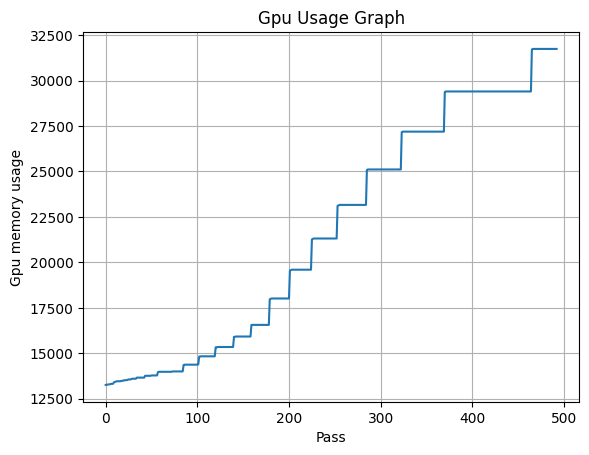

In [8]:
import matplotlib.pyplot as plt

# Sample array of numbers
data = output[1]

# Create a time array (assuming equal intervals, e.g., time steps)
time = range(len(data))

# Plot the time series
plt.plot(time, data)
plt.xlabel('Pass')
plt.ylabel('Gpu memory usage')
plt.title('Gpu Usage Graph')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Sample array of numbers
data = output[1]

# Create a time array (assuming equal intervals, e.g., time steps)
time = range(len(data))

# Plot the time series
plt.plot(time, data)
plt.xlabel('Pass')
plt.ylabel('Gpu memory usage')
plt.title('Gpu Usage Graph')
plt.grid(True)
plt.show()